<a href="https://colab.research.google.com/github/zhesun0304/ECON3916/blob/main/Assignment%201/Econ_3916_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Assignment 1: The Cost of Living Crisis
# Phase 1: Prepare (Logic & Control Flow)

# Step 1.1: Construct the "Student Basket"
# Manaul Data Construction
student_basket = [
  {'Item': 'Tuition', 'Price_2016':45000, 'Price_2024':58000},
  {'Item': 'Spotify', 'Price_2016':120, 'Price_2024':150},
  {'Item': 'Rent (1 Bed)', 'Price_2016':1200, 'Price_2024':1800},
  {'Item': 'Chipotle Burrito', 'Price_2016':7.50, 'Price_2024':11.50}
]

#  1.2: Compute Inflation (Loops & Functions)
# Define the "Machine" (Function)
def calculate_inflation(base, current):
  return((current - base) / base) * 100

# Run the Loop
for item in student_basket:
  rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
  print(f"{item['Item']}: {rate:.2f}% Inflation")



Tuition: 28.89% Inflation
Spotify: 25.00% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation


In [46]:
# Phase 2: Process (The API Pipeline)
# Step 2.1: The "Data Proxy" Strategy
!pip install fredapi
from fredapi import Fred
fred = Fred(api_key = 'd47f4eb0fdd4d4b756294b0bab31d4f8')

# Fetch series
official_cpi = fred.get_series('CPIAUCSL')
tuition = fred.get_series('CUSR0000SEEB')
rent = fred.get_series('CUSR0000SEHA')
spotify = fred.get_series('CUSR0000SERA02')
chipotle = fred.get_series('CUSR0000SEFV')


In [47]:
# Step 2.2: Normalization Logic (CRITICAL)
import pandas as pd

# Combine into one DataFrame (do NOT slice to 2016 here)
df_raw = pd.DataFrame({
    "Official_CPI": official_cpi,
    "Tuition_CPI": tuition,
    "Rent_CPI": rent,
    "Spotify_CPI": spotify,
    "Chipotle_CPI": chipotle
}).sort_index()

START_DATE = "2016-01-01"

def reindex_to_2016(s, start_date=START_DATE):
    base = s.loc[start_date]          # value at 2016-01-01
    return (s / base) * 100

df_norm = df_raw.apply(reindex_to_2016)

Value_at_Start_Date = official_cpi.loc['2016-01-01']
Value_Current = official_cpi.loc['2024-01-01']
Value_Index = (Value_Current / Value_at_Start_Date) * 100


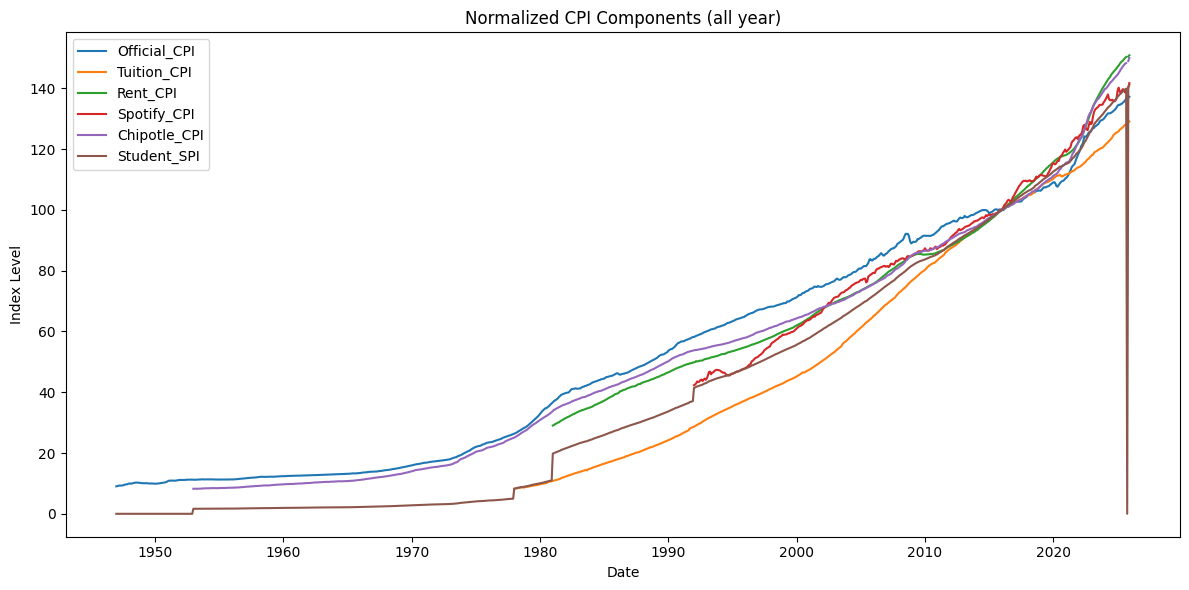

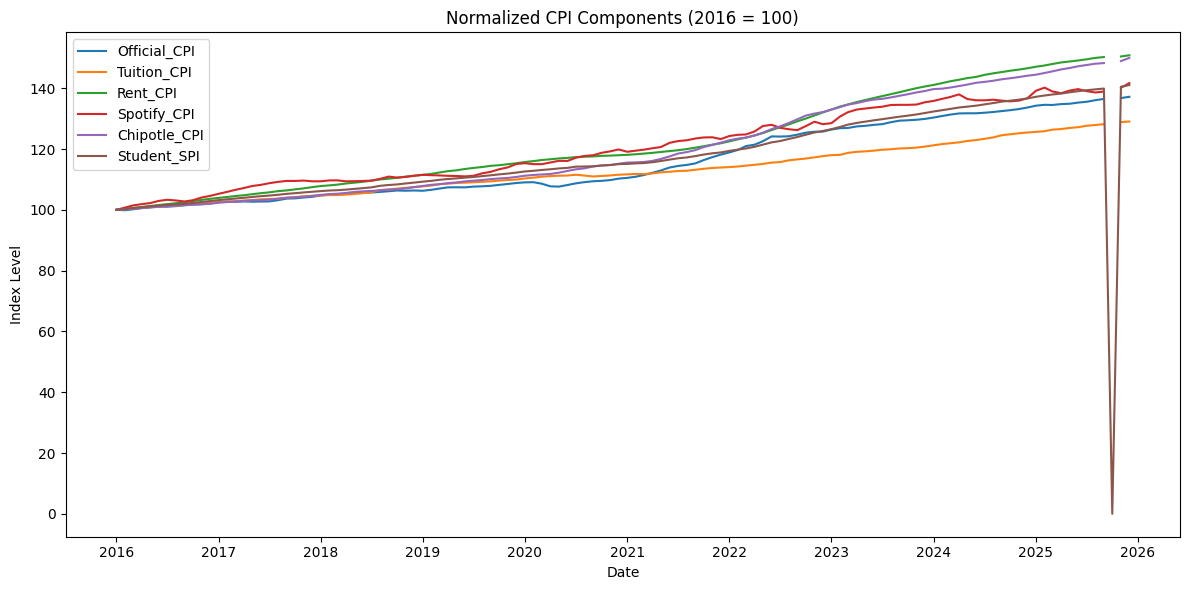

In [52]:
# Phase 3: Analyze (The Index Theory & Visualization)
# Step 3.1: Visualizing Raw Components (beginning of data version)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)

plt.title("Normalized CPI Components (all year)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()

# Step 3.1.2: Visualizing Raw Components (Normalized, starting from 2016)
df_plot = df_norm.loc["2016-01-01":]

plt.figure(figsize=(12,6))

for col in df_plot.columns:
    plt.plot(df_plot.index, df_plot[col], label=col)

plt.title("Normalized CPI Components (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()

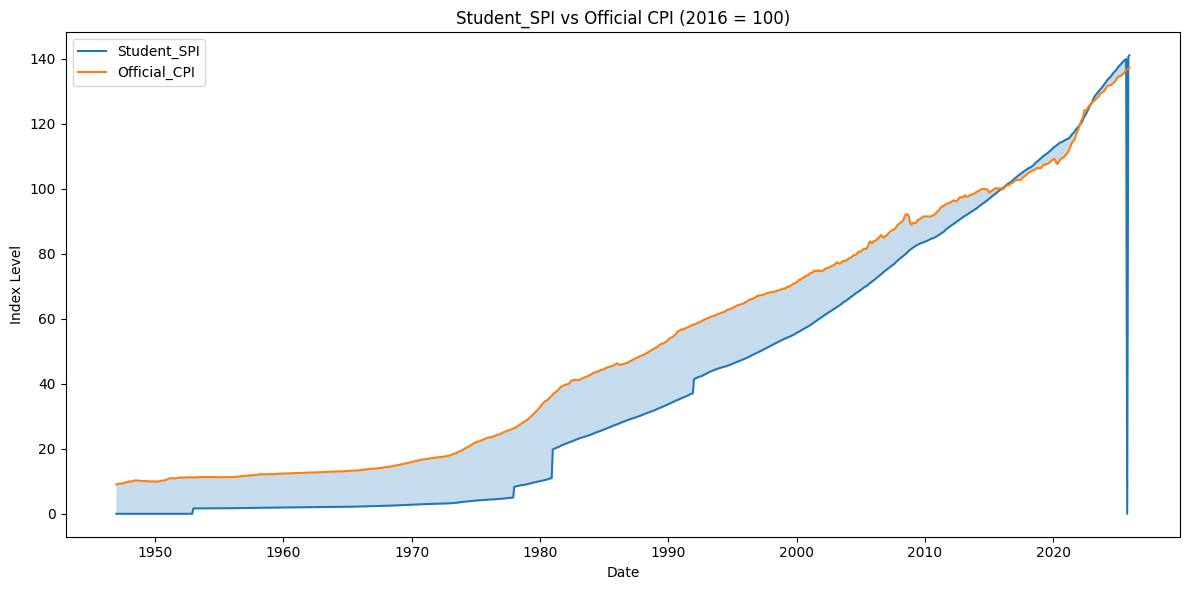

In [49]:
# Step 3.2: The Weighted "Student SPI" (Honest Chart)
weights = {
    "Tuition_CPI": 0.40,
    "Rent_CPI": 0.30,
    "Spotify_CPI": 0.10,
    "Chipotle_CPI": 0.20
}

df_norm["Student_SPI"] = (
    df_norm[list(weights.keys())]
    .mul(pd.Series(weights))
    .sum(axis=1)
)

plt.figure(figsize=(12,6))

plt.plot(df_norm.index, df_norm["Student_SPI"], label="Student_SPI")
plt.plot(df_norm.index, df_norm["Official_CPI"], label="Official_CPI")

# Shade the area between the two lines (the "inflation gap")
plt.fill_between(
    df_norm.index,
    df_norm["Official_CPI"],
    df_norm["Student_SPI"],
    alpha=0.25
)

plt.title("Student_SPI vs Official CPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()


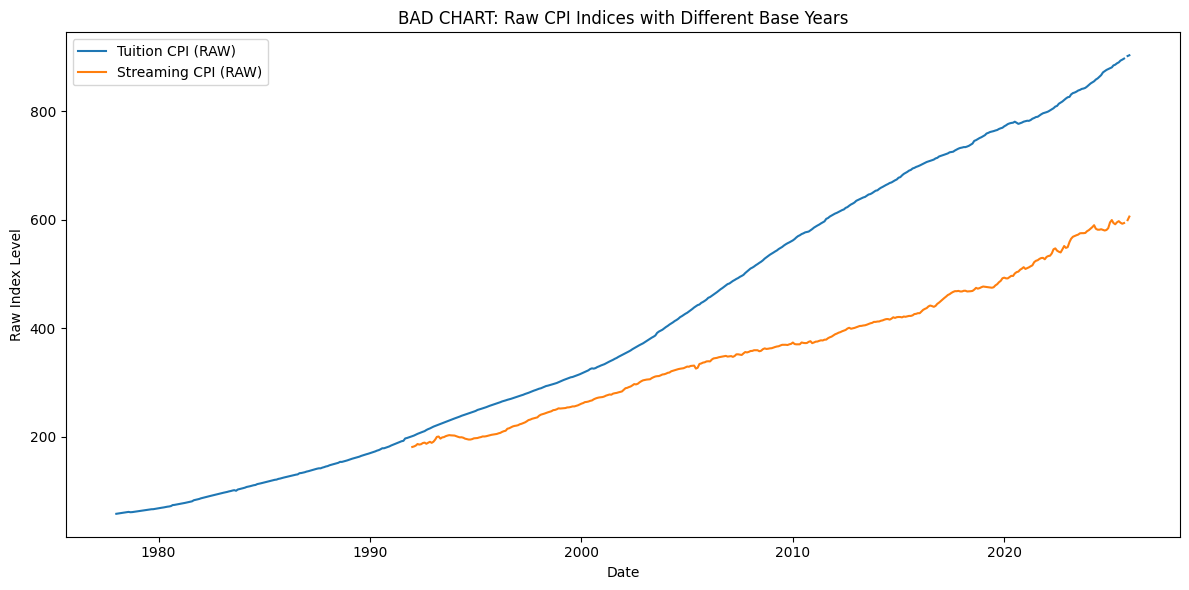

In [50]:
# Step 3.3: The Scale Fallacy (Why We Normalize)
plt.figure(figsize=(12,6))

plt.plot(df_raw.index, df_raw["Tuition_CPI"], label="Tuition CPI (RAW)")
plt.plot(df_raw.index, df_raw["Spotify_CPI"], label="Streaming CPI (RAW)")

plt.title("BAD CHART: Raw CPI Indices with Different Base Years")
plt.xlabel("Date")
plt.ylabel("Raw Index Level")
plt.legend()
plt.tight_layout()
plt.show()



## Why this visualization is a "Data Crime"

This chart is misleading because CPI series are index numbers constructed using different base years. The tuition CPI is indexed to a 1982 base, while the spotify CPI is indexed to a later base year. As a result, their raw index levels like mangituds above 900 and that around 100 are not directly comparable and do not actually reflect difference or relavances.

Values are only meaningful relative to their own base period. Plotting raw CPI series together wrongly suggests that tuition are naturally larger or more significant than spotify prices, when the difference is driven entirely by other factors.

Proper comparison requires re-indexing all series to a common base year like 2016, so that differences reflect growth rates over time.

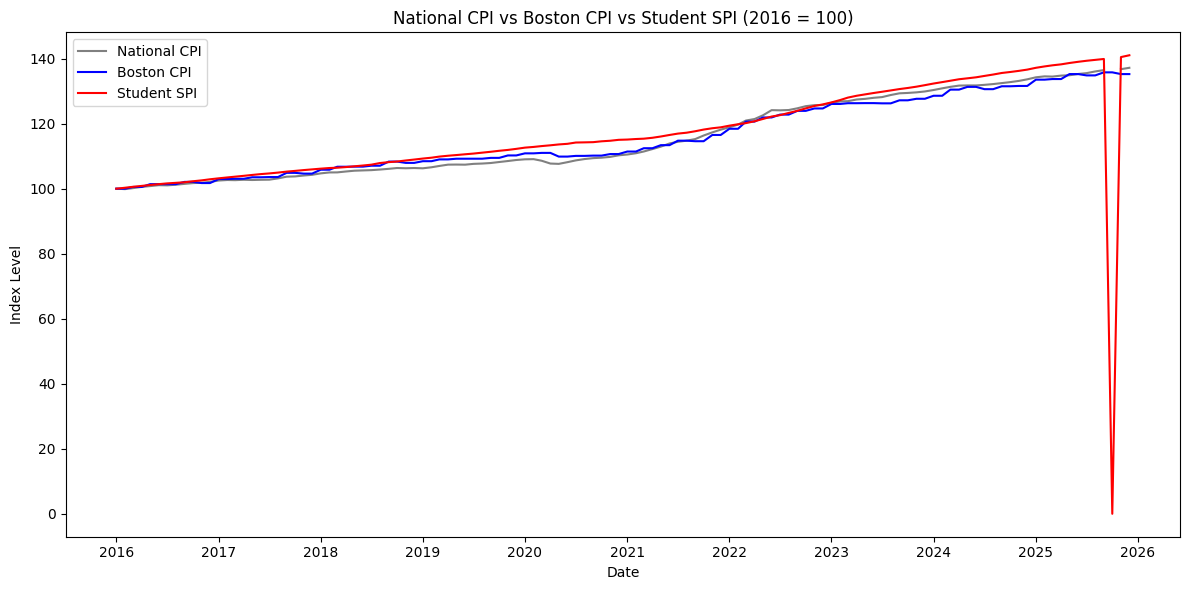

In [51]:
# Phase 4: AI Expansion (The Co-Pilot Era)
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# --- 1) Fetch Boston CPI from FRED ---
# Boston-Cambridge-Newton CPI-U (All Items): CUURA103SA0
boston_raw = fred.get_series("CUURA103SA0")  # monthly (sometimes bimonthly behavior)

# --- 2) Re-index Boston series so 2016-01-01 = 100 ---
START_DATE = "2016-01-01"

# If 2016-01-01 exists exactly, this works; otherwise it falls back to first obs >= start.
try:
    base = boston_raw.loc[START_DATE]
except KeyError:
    base = boston_raw.loc[boston_raw.index >= START_DATE].iloc[0]

boston_norm = (boston_raw / base) * 100
boston_norm.name = "Boston_CPI"

# --- 3) Align frequency / handle missing values ---
# Make sure Boston CPI is aligned to df's index; forward-fill handles gaps/bimonthly patterns.
df_plot = df_norm.copy()
df_plot["Boston_CPI"] = boston_norm.reindex(df_plot.index).ffill()

# (Optional) For the "starts at 100" visual, plot from 2016 onward:
df_plot = df_plot.loc["2016-01-01":, ["Official_CPI", "Boston_CPI", "Student_SPI"]]

# --- 4) Plot 3 lines: National CPI, Boston CPI, Student SPI ---
plt.figure(figsize=(12,6))
plt.plot(df_plot.index, df_plot["Official_CPI"], label="National CPI", color="grey")
plt.plot(df_plot.index, df_plot["Boston_CPI"], label="Boston CPI", color="blue")
plt.plot(df_plot.index, df_plot["Student_SPI"], label="Student SPI", color="red")

plt.title("National CPI vs Boston CPI vs Student SPI (2016 = 100)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.tight_layout()
plt.show()
